In [1]:
import numpy as np
from scipy.stats import chi2
from itertools import product
import matplotlib.pyplot as plt
import time

In [2]:
def gtest(X, Y, Z):
    """
    The G test can test for goodness of fit to a distribution.
    We are here testing the null hypothesis X \perp Y |Z
    Note X, Y, Z are all binary variables
    Parameters
    ----------
    X : array
    Y : array
    Z : n*d matrix with d number of conditioned variables
    ddof : int, optional
        adjustment to the degrees of freedom for the p-value
    Returns
    -------
    chisquare statistic : float
        The chisquare test statistic
    p : float
        The p-value of the test.
    Notes
    -----
    """
    assert len(X) == len(Y)
    n = Z.shape[1]
    df = 2**n
    EmpTable = np.zeros((2, 2, df))
    conditionedset = list(product([0, 1], repeat=n))
    for x in [0, 1]:
        for y in [0, 1]:
            for z in conditionedset:
                xindex = set(np.where(X == x)[0])
                yindex = set(np.where(Y == y)[0])
                valid_index = xindex.intersection(yindex)
                for i in range(len(z)):
                    valid_index = valid_index.intersection(set(np.where(Z[:,i] == z[i])[0]))
                ind = conditionedset.index(z)
                EmpTable[x, y, ind] = len(valid_index)
        
    ExpTable = np.zeros((2, 2, df))
    for x in [0, 1]:
        for y in [0, 1]:
            for z in range(len(conditionedset)):
                ExpTable[x, y, z] = np.sum(EmpTable[x, :, z])*np.sum(EmpTable[:, y, z])
                ExpTable[x, y, z] /= np.sum(EmpTable[:, :, z])
    prop = EmpTable.reshape(-1) * np.log((EmpTable/ExpTable).reshape(-1))
    prop = np.nan_to_num(prop)
    g = 2* np.sum(prop)
    sig = chi2.sf(g, df)
    return g, sig 

In [3]:
def test_topological_order(var_dict):
    """
    Here focus on 2 samples in each environment.
    Input: var_dict = {var_name: var_value}, where var_value is a num_sample * num_env matrix
    Output: sink_dict = {i: []}
            keys: ranging from 0 to n, where n is number of variables
            values: is the list of var_names that belong to S_i
    """
    # print("sink_dict:")
    n = len(var_dict.keys())
    var_names = set(var_dict.keys())
    sink_dict = {}
    for key in range(n+1):
        sink_dict[key] = []
    for i in range(1, n+1, 1):
        # print(i)
        # Find which variables need to be tested. 
        test_vars = var_names
        for j in range(i):
            test_vars = test_vars ^ set(sink_dict[j]) # Exclude all that have been classified before
        # print(test_vars)
        for var in test_vars:
            # print(var)
            Xji = var_dict[var][0,:]
            # Look for valid set for S>=n
            exc_vars = test_vars ^ set([var])
            is_var_in_cur_sink = False
            if len(exc_vars) == 0:
                is_var_in_cur_sink = True
            else:
                sigtable = {}
                for k in exc_vars:
                    Xkl = var_dict[k][1,:]
                    con_vars = np.stack([var_dict[m][0,:] for m in exc_vars], axis = 1)
                    _, sig = gtest(Xji, Xkl, con_vars)
                    # print(var, k, exc_vars, sig)
                    sigtable[k] = sig
                if all(v >= 0.05 for v in list(sigtable.values())):
                    is_var_in_cur_sink = True
            if is_var_in_cur_sink:
                sink_dict[i].append(var)
    return sink_dict

In [4]:
def test_edge(sink_dict, var_dict):
    """
    Input: sink_dict
           var_dict
    Output: edge_dict = {var_name: [list of var names that is its children]}
    """
    N = len(var_dict.keys())
    edge_dict = {}
    for key in var_dict.keys():
        edge_dict[key] = []
    for d in range(1, N, 1):
        for n in range(1+d, N+1, 1):
            if d == 1:
                # print(d, n)
                bigger_n_keys = [k for k in sink_dict.keys() if k > n]
                if len(bigger_n_keys) == 0:
                    S_bigger_n = []
                else:
                    S_bigger_n = [v for k in bigger_n_keys for v in sink_dict[k]]
                for Xji_name in sink_dict[n]:
                    for Xki_name in sink_dict[n-d]:
                        Xji = var_dict[Xji_name][0,:]
                        Xki = var_dict[Xki_name][0,:]
                        if len(S_bigger_n) == 0:
                            con_vars = np.matrix([])
                        else:
                            con_vars = np.stack([var_dict[v][0,:] for v in S_bigger_n], axis = 1)
                        _, sig = gtest(Xji, Xki, con_vars)
                        # print(Xji_name, Xki_name, S_bigger_n, sig)
                        if sig <= 0.05:
                            edge_dict[Xji_name].append(Xki_name)
            if d >=2:
                # print(d, n)
                # Need to condition on S>n set
                bigger_n_keys = [k for k in sink_dict.keys() if k > n]
                if len(bigger_n_keys) == 0:
                    S_bigger_n = []
                else:
                    S_bigger_n = [v for k in bigger_n_keys for v in sink_dict[k]]
                # print(S_bigger_n)
                for Xji_name in sink_dict[n]:
                    for Xki_name in sink_dict[n-d]:
                        Xji = var_dict[Xji_name][0,:]
                        Xki = var_dict[Xki_name][0,:]
                        # Need to condition on pa(ch(Xji)) interesect Sn
                        coparent = []
                        for child in edge_dict[Xji_name]:
                            for k, v in edge_dict.items():
                                if child in v:
                                    if k in sink_dict[n] and k != Xji_name:
                                        coparent.append(k)
                        # print(coparent)
                        # Need to condition on non-collider intermediary nodes pa(Xki)
                        IM = []
                        for k, v in edge_dict.items():
                            if Xki_name in v:
                                if k not in S_bigger_n and k not in sink_dict[n]:
                                    IM.append(k)
                        # print(IM)
                        con_vars_name = list(set(S_bigger_n) | set(coparent)| set(IM))
                        if len(con_vars_name) == 0:
                            con_vars = np.matrix([])
                        else:
                            con_vars = np.stack([var_dict[v][0,:] for v in con_vars_name], axis = 1)
         
                        _, sig = gtest(Xji, Xki, con_vars)
                        # print(Xji_name, Xki_name, con_vars_name, sig)
                        if sig <= 0.05:
                            edge_dict[Xji_name].append(Xki_name)
                        
    return edge_dict

In [5]:
def most_common(res):
    out = {}
    for v in res.values():
        hashv = freeze(v)
        if str(hashv) not in list(out.keys()):
            out[str(hashv)] = 1
        else:
            out[str(hashv)] += 1
    return sorted(out.items())

In [6]:
def build_edge_tuple(edge_dict):
    out = []
    for key, value in edge_dict.items():
        if len(value) != 0:
            for v in value:
                out.append((key, v))
    return out

In [7]:
def show_graph(edge_dict, edge_sig):

    graph = nx.DiGraph()
    edge_list = build_edge_tuple(edge_dict)
    graph.add_edges_from(edge_list)
    options = {
        "node_size": 3000,
        "node_color": "white",
        "edgecolors": "black",
        "width": 3,
        "arrowsize": 20
    }
    alphas = list(edge_sig.values())
    if len(edge_dict.keys()) == 3:
        pos = {"A": (0, 0), "B": (1, 1), "C": (2, 0)}
    if len(edge_dict.keys()) == 4:
        pos = {"A": (0, 0), "B": (1, 1), "C": (3, 1), "D":(4, 0)}
    arcs = nx.draw_networkx_edges(graph,  pos)
    for i, arc in enumerate(arcs):  # change alpha values of arcs
        arc.set_alpha(alphas[i])
    nx.draw_networkx_edge_labels(
    graph, pos ,
    edge_labels= edge_sig,
    font_color='blue'
    )
    nx.draw_networkx(graph, pos, arrows=True, **options)
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    plt.show()

# Experiment 1


$$A \rightarrow B \quad \text{and} \quad A \rightarrow C$$

$$
\theta_A \sim \text{Beta}(\alpha, \beta) \\
\theta_B \sim \text{Beta}(\alpha, \beta) \\
\theta_C \sim \text{Beta}(\alpha, \beta) \\
A \sim \text{Ber}(\theta_A) \\
B \sim \text{Ber}(\theta_B) \quad \text{xor} \quad A \\
C \sim \text{Ber}(\theta_C) \quad \text{xor} \quad A \\
$$

Experiment 0 finished.
Progress: 0.01
Experiment 20 finished.
Progress: 0.19
Experiment 40 finished.
Progress: 0.36
Experiment 60 finished.
Progress: 0.56
Experiment 80 finished.
Progress: 0.73
Final: 0.91
{('A', 'B'): 0.97, ('A', 'C'): 0.97}


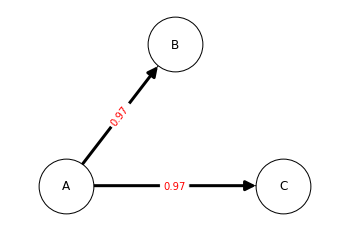

In [81]:
# Many environments only 2 samples in each environment
num_experiments = 100
right_sink = {0: [], 1: ['B', 'C'], 2: ['A'], 3: []}
right_edge = {'A': ['B', 'C'], 'B': [], 'C': []}
right_edge_list = build_edge_tuple(right_edge)
edge_sig = {}
for pair in right_edge_list:
    edge_sig[pair] = 0 
res = {}
correct_num = 0
correct_rate = []
for i in range(num_experiments):
    np.random.seed(i)
    num_env = 10000
    num_sample = 2
    alpha = 1
    beta = 3
    # Generate Data
    theta_a = np.random.beta(alpha, beta, num_env)
    theta_b = np.random.beta(alpha, beta, num_env)
    theta_c = np.random.beta(alpha, beta, num_env)
    A = np.random.binomial(1, p = theta_a, size = (num_sample, num_env))
    B_factor = np.random.binomial(1, p = theta_b, size = (num_sample, num_env))
    C_factor = np.random.binomial(1, p = theta_c, size = (num_sample, num_env))
    B = (B_factor != A).astype(int)
    C = (C_factor != A).astype(int)
    var_dict = {'A': A, 'B': B, 'C': C}


    sink_dict = test_topological_order(var_dict)
    edge_dict = test_edge(sink_dict, var_dict)
    res[i] = (sink_dict, edge_dict)
    if sink_dict == right_sink and edge_dict == right_edge:
        correct_num += 1
    correct_rate.append(correct_num/num_experiments)
    cur_edge_list = build_edge_tuple(edge_dict)
    for pair in right_edge_list:
        if pair in cur_edge_list:
            edge_sig[pair] += 1/num_experiments
    """
    else:
        print(i)
        print(sink_dict)
        print(edge_dict)
    """  
    if i%20 ==0:
        print("Experiment %d finished." %(i)) 
        print("Progress: %.2f" %(correct_num/num_experiments))
print("Final: %.2f" %(correct_num/num_experiments))
for k, v in edge_sig.items():
    v = round(v, 2)
    edge_sig[k] = v
print(edge_sig)
show_graph(right_edge, edge_sig)

# Experiment 2


$$A \rightarrow B \quad \text{and} \quad B \rightarrow C$$

$$
\theta_A \sim \text{Beta}(\alpha, \beta) \\
\theta_B \sim \text{Beta}(\alpha, \beta) \\
\theta_C \sim \text{Beta}(\alpha, \beta) \\
A \sim \text{Ber}(\theta_A) \\
B \sim \text{Ber}(\theta_B) \quad \text{xor} \quad A \\
C \sim \text{Ber}(\theta_C) \quad \text{xor} \quad B \\
$$

Experiment 0 finished.
Progress: 0.01
Experiment 20 finished.
Progress: 0.19
Experiment 40 finished.
Progress: 0.32
Experiment 60 finished.
Progress: 0.49
Experiment 80 finished.
Progress: 0.65
Final: 0.80
{('A', 'B'): 0.9, ('B', 'C'): 0.85}


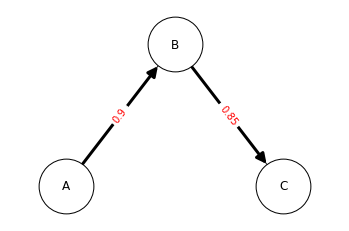

In [82]:
# Many environments only 2 samples in each environment
num_experiments = 100
right_sink = {0: [], 1: ['C'], 2: ['B'], 3: ['A']}
right_edge = {'A': ['B'], 'B': ['C'], 'C': []}
right_edge_list = build_edge_tuple(right_edge)
edge_sig = {}
for pair in right_edge_list:
    edge_sig[pair] = 0 
res = {}
correct_rate = 0 
for i in range(num_experiments):
    np.random.seed(i)
    num_env = 10000
    num_sample = 2
    alpha = 1
    beta = 3
    # Generate Data
    theta_a = np.random.beta(alpha, beta, num_env)
    theta_b = np.random.beta(alpha, beta, num_env)
    theta_c = np.random.beta(alpha, beta, num_env)
    A = np.random.binomial(1, p = theta_a, size = (num_sample, num_env))
    B_factor = np.random.binomial(1, p = theta_b, size = (num_sample, num_env))
    C_factor = np.random.binomial(1, p = theta_c, size = (num_sample, num_env))
    B = (B_factor != A).astype(int)
    C = (C_factor != B).astype(int)
    var_dict = {'A': A, 'B': B, 'C': C}


    sink_dict = test_topological_order(var_dict)
    edge_dict = test_edge(sink_dict, var_dict)
    res[i] = [sink_dict, edge_dict]
    if sink_dict == right_sink and edge_dict == right_edge:
        correct_rate += 1
    cur_edge_list = build_edge_tuple(edge_dict)
    for pair in right_edge_list:
        if pair in cur_edge_list:
            edge_sig[pair] += 1/num_experiments
    """
    else:
        print(i)
        print(sink_dict)
        print(edge_dict)
    """  
    if i%20 ==0:
        print("Experiment %d finished." %(i)) 
        print("Progress: %.2f" %(correct_rate/num_experiments))
print("Final: %.2f" %(correct_rate/num_experiments))
for k, v in edge_sig.items():
    v = round(v, 2)
    edge_sig[k] = v
print(edge_sig)
show_graph(right_edge, edge_sig)

# Experiment 3


$$B \rightarrow A \quad \text{and} \quad C \rightarrow A$$
$$
\theta_A \sim \text{Beta}(\alpha, \beta) \\
\theta_B \sim \text{Beta}(\alpha, \beta) \\
\theta_C \sim \text{Beta}(\alpha, \beta) \\
B \sim \text{Ber}(\theta_B) \\
C \sim \text{Ber}(\theta_C) \\
A \sim \text{Ber}(\theta_A) \quad \text{xor} \quad B \quad \text{xor} \quad C\\
$$

Experiment 0 finished.
Progress: 0.00
Experiment 20 finished.
Progress: 0.11
Experiment 40 finished.
Progress: 0.28
Experiment 60 finished.
Progress: 0.45
Experiment 80 finished.
Progress: 0.60
Final: 0.71
{('B', 'A'): 0.83, ('C', 'A'): 0.82}


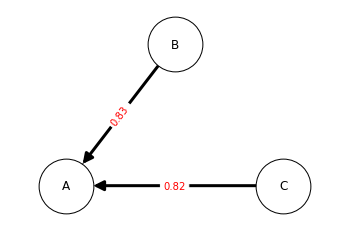

In [83]:
num_experiments = 100
right_sink = {0: [], 1: ['A'], 2: ['B', 'C'], 3: []}
right_edge = {'A': [], 'B': ['A'], 'C': ['A']}
right_edge_list = build_edge_tuple(right_edge)
edge_sig = {}
for pair in right_edge_list:
    edge_sig[pair] = 0 
res = {}
correct_rate = 0 
for i in range(num_experiments):
    np.random.seed(i)
    num_env = 10000
    num_sample = 2
    alpha = 1
    beta = 3
    # Generate Data
    theta_a = np.random.beta(alpha, beta, num_env)
    theta_b = np.random.beta(alpha, beta, num_env)
    theta_c = np.random.beta(alpha, beta, num_env)
    A_factor = np.random.binomial(1, p = theta_a, size = (num_sample, num_env))
    B = np.random.binomial(1, p = theta_b, size = (num_sample, num_env))
    C = np.random.binomial(1, p = theta_c, size = (num_sample, num_env))
    A = (A_factor != B).astype(int)
    A = (A != C).astype(int)
    var_dict = {'A': A, 'B': B, 'C': C}


    sink_dict = test_topological_order(var_dict)
    edge_dict = test_edge(sink_dict, var_dict)
    res[i] = [sink_dict, edge_dict]
    if sink_dict == right_sink and edge_dict == right_edge:
        correct_rate += 1
    cur_edge_list = build_edge_tuple(edge_dict)
    for pair in right_edge_list:
        if pair in cur_edge_list:
            edge_sig[pair] += 1/num_experiments
    """
    else:
        print(i)
        print(sink_dict)
        print(edge_dict)
    """  
    if i%20 ==0:
        print("Experiment %d finished." %(i)) 
        print("Progress: %.2f" %(correct_rate/num_experiments))
print("Final: %.2f" %(correct_rate/num_experiments))
for k, v in edge_sig.items():
    v = round(v, 2)
    edge_sig[k] = v
print(edge_sig)
show_graph(right_edge, edge_sig)

# Experiment 4


$$A \rightarrow B \quad \text{and} \quad B \rightarrow C \quad \text{and} \quad A \rightarrow C$$
$$
\theta_A \sim \text{Beta}(\alpha, \beta) \\
\theta_B \sim \text{Beta}(\alpha, \beta) \\
\theta_C \sim \text{Beta}(\alpha, \beta) \\
A \sim \text{Ber}(\theta_A) \\
B \sim \text{Ber}(\theta_B) \quad \text{xor} \quad A \\
C \sim \text{Ber}(\theta_C) \quad \text{xor} \quad A \times B \\
$$

Experiment 0 finished.
Progress: 0.01
Experiment 20 finished.
Progress: 0.18
Experiment 40 finished.
Progress: 0.34
Experiment 60 finished.
Progress: 0.52
Experiment 80 finished.
Progress: 0.68
Final: 0.86
{('A', 'B'): 0.9, ('A', 'C'): 0.9, ('B', 'C'): 0.86}


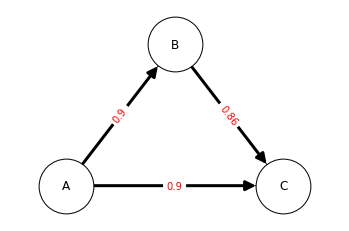

In [84]:
# Many environments only 2 samples in each environment
num_experiments = 100
right_sink = {0: [], 1: ['C'], 2: ['B'], 3: ['A']}
right_edge = {'A': ['B', 'C'], 'B': ['C'], 'C': []}
right_edge_list = build_edge_tuple(right_edge)
edge_sig = {}
for pair in right_edge_list:
    edge_sig[pair] = 0 
res = {}
correct_rate = 0 
for i in range(num_experiments):
    np.random.seed(i)
    num_env = 10000
    num_sample = 2
    alpha = 1
    beta = 3
    # Generate Data
    theta_a = np.random.beta(alpha, beta, num_env)
    theta_b = np.random.beta(alpha, beta, num_env)
    theta_c = np.random.beta(alpha, beta, num_env)
    A = np.random.binomial(1, p = theta_a, size = (num_sample, num_env))
    B_factor = np.random.binomial(1, p = theta_b, size = (num_sample, num_env))
    C_factor = np.random.binomial(1, p = theta_c, size = (num_sample, num_env))
    B = (B_factor != A).astype(int)
    C = (C_factor != (A*B)).astype(int)
    var_dict = {'A': A, 'B': B, 'C': C}


    sink_dict = test_topological_order(var_dict)
    edge_dict = test_edge(sink_dict, var_dict)
    res[i] = [sink_dict, edge_dict]
    if sink_dict == right_sink and edge_dict == right_edge:
        correct_rate += 1
    cur_edge_list = build_edge_tuple(edge_dict)
    for pair in right_edge_list:
        if pair in cur_edge_list:
            edge_sig[pair] += 1/num_experiments
    """
    else:
        print(i)
        print(sink_dict)
        print(edge_dict)
    """    
    if i%20 ==0:
        print("Experiment %d finished." %(i)) 
        print("Progress: %.2f" %(correct_rate/num_experiments))
print("Final: %.2f" %(correct_rate/num_experiments))
for k, v in edge_sig.items():
    v = round(v, 2)
    edge_sig[k] = v
print(edge_sig)
show_graph(right_edge, edge_sig)

# Experiment 5

$$B \rightarrow A \quad \text{and} \quad C \rightarrow A \quad \text{and} \quad B \rightarrow C$$

$$
\theta_A \sim \text{Beta}(\alpha, \beta) \\
\theta_B \sim \text{Beta}(\alpha, \beta) \\
\theta_C \sim \text{Beta}(\alpha, \beta) \\
B \sim \text{Ber}(\theta_B) \\
C \sim \text{Ber}(\theta_C) \quad \text{xor} \quad B  \\
A \sim \text{Ber}(\theta_A) \quad \text{xor} \quad B \times C\\
$$

Experiment 0 finished.
Progress: 0.01
Experiment 20 finished.
Progress: 0.19
Experiment 40 finished.
Progress: 0.38
Experiment 60 finished.
Progress: 0.55
Experiment 80 finished.
Progress: 0.73
Final: 0.87
{('B', 'C'): 0.91, ('B', 'A'): 0.91, ('C', 'A'): 0.87}


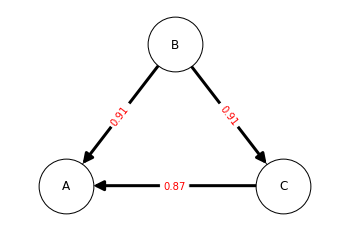

In [85]:
num_experiments = 100
right_sink = {0: [], 1: ['A'], 2: ['C'], 3: ['B']}
right_edge = {'A': [], 'B': ['C', 'A'], 'C': ['A']}
right_edge_list = build_edge_tuple(right_edge)
edge_sig = {}
for pair in right_edge_list:
    edge_sig[pair] = 0 
res = {}
correct_rate = 0 
for i in range(num_experiments):
    np.random.seed(i)
    num_env = 10000
    num_sample = 2
    alpha = 1
    beta = 3
    # Generate Data
    theta_a = np.random.beta(alpha, beta, num_env)
    theta_b = np.random.beta(alpha, beta, num_env)
    theta_c = np.random.beta(alpha, beta, num_env)
    A_factor = np.random.binomial(1, p = theta_a, size = (num_sample, num_env))
    B = np.random.binomial(1, p = theta_b, size = (num_sample, num_env))
    C_factor = np.random.binomial(1, p = theta_c, size = (num_sample, num_env))
    C = (C_factor != B).astype(int)
    A = (A_factor != (B*C)).astype(int)
    var_dict = {'A': A, 'B': B, 'C': C}


    sink_dict = test_topological_order(var_dict)
    edge_dict = test_edge(sink_dict, var_dict)
    res[i] = [sink_dict, edge_dict]
    if sink_dict == right_sink and edge_dict == right_edge:
        correct_rate += 1
    cur_edge_list = build_edge_tuple(edge_dict)
    for pair in right_edge_list:
        if pair in cur_edge_list:
            edge_sig[pair] += 1/num_experiments
    """
    else:
        print(i)
        print(sink_dict)
        print(edge_dict)
    """
    if i%20 ==0:
        print("Experiment %d finished." %(i)) 
        print("Progress: %.2f" %(correct_rate/num_experiments))
print("Final: %.2f" %(correct_rate/num_experiments))
for k, v in edge_sig.items():
    v = round(v, 2)
    edge_sig[k] = v
print(edge_sig)
show_graph(right_edge, edge_sig)

# Experiment 6
$$A \rightarrow B \quad \text{and} \quad B \rightarrow C \quad C \rightarrow D$$
$$
\theta_A \sim \text{Beta}(\alpha, \beta) \\
\theta_B \sim \text{Beta}(\alpha, \beta) \\
\theta_C \sim \text{Beta}(\alpha, \beta) \\
A \sim \text{Ber}(\theta_A) \\
B \sim \text{Ber}(\theta_B) \quad \text{xor} \quad A \\
C \sim \text{Ber}(\theta_C) \quad \text{xor} \quad B \\
D \sim \text{Ber}(\theta_D) \quad \text{xor} \quad C \\
$$

Experiment 0 finished.
Progress: 0.00
Experiment 10 finished.
Progress: 0.09
Experiment 20 finished.
Progress: 0.15
Experiment 30 finished.
Progress: 0.21
Experiment 40 finished.
Progress: 0.26
Experiment 50 finished.
Progress: 0.31
Experiment 60 finished.
Progress: 0.38
Experiment 70 finished.
Progress: 0.46
Experiment 80 finished.
Progress: 0.54
Experiment 90 finished.
Progress: 0.57
Final: 0.60
Time Taken: 1412.598988
{('A', 'B'): 0.73, ('B', 'C'): 0.73, ('C', 'D'): 0.78}


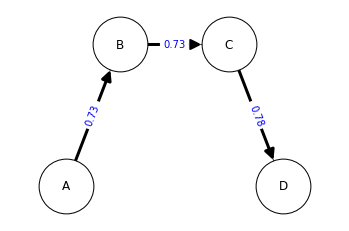

In [91]:
# Many environments only 2 samples in each environment
start_time = time.time()
num_experiments = 100
right_sink = {0: [], 1: ['D'], 2: ['C'], 3: ['B'], 4: ['A']}
right_edge = {'A': ['B'], 'B': ['C'], 'C': ['D'], 'D': []}
right_edge_list = build_edge_tuple(right_edge)
edge_sig = {}
for pair in right_edge_list:
    edge_sig[pair] = 0 
res = {}
correct_rate = 0 
for i in range(num_experiments):
    np.random.seed(i)
    num_env = 100000
    num_sample = 2
    alpha = 1
    beta = 3
    # Generate Data
    theta_a = np.random.beta(alpha, beta, num_env)
    theta_b = np.random.beta(alpha, beta, num_env)
    theta_c = np.random.beta(alpha, beta, num_env)
    theta_d = np.random.beta(alpha, beta, num_env)
    A = np.random.binomial(1, p = theta_a, size = (num_sample, num_env))
    B_factor = np.random.binomial(1, p = theta_b, size = (num_sample, num_env))
    C_factor = np.random.binomial(1, p = theta_c, size = (num_sample, num_env))
    D_factor = np.random.binomial(1, p = theta_d, size = (num_sample, num_env))
    B = (B_factor != A).astype(int)
    C = (C_factor != B).astype(int)
    D = (D_factor != C).astype(int)
    var_dict = {'A': A, 'B': B, 'C': C, 'D': D}

    sink_dict = test_topological_order(var_dict)
    # print(sink_dict)
    edge_dict = test_edge(sink_dict, var_dict)
    res[i] = (sink_dict, edge_dict)
    if sink_dict == right_sink and edge_dict == right_edge:
        correct_rate += 1
    cur_edge_list = build_edge_tuple(edge_dict)
    for pair in right_edge_list:
        if pair in cur_edge_list:
            edge_sig[pair] += 1/num_experiments
    """
    else:
        print(i)
        print(sink_dict)
        print(edge_dict)
    """    
    if i%10 ==0:
        print("Experiment %d finished." %(i)) 
        print("Progress: %.2f" %(correct_rate/num_experiments))
print("Final: %.2f" %(correct_rate/num_experiments))
print("Time Taken: %.6f" %(time.time() - start_time))
for k, v in edge_sig.items():
    v = round(v, 2)
    edge_sig[k] = v
print(edge_sig)
show_graph(right_edge, edge_sig)

# Experiment 7
$$A \rightarrow B \quad \text{and} \quad B \rightarrow C \quad \text{and} \quad C \rightarrow D \quad \text{and} \quad B\rightarrow D $$
$$
\theta_A \sim \text{Beta}(\alpha, \beta) \\
\theta_B \sim \text{Beta}(\alpha, \beta) \\
\theta_C \sim \text{Beta}(\alpha, \beta) \\
A \sim \text{Ber}(\theta_A) \\
B \sim \text{Ber}(\theta_B) \quad \text{xor} \quad A \\
C \sim \text{Ber}(\theta_C) \quad \text{xor} \quad B \\
D \sim \text{Ber}(\theta_D) \quad \text{xor} \quad C \times B \\
$$

Experiment 0 finished.
Progress: 0.00
Experiment 10 finished.
Progress: 0.09
Experiment 20 finished.
Progress: 0.15
Experiment 30 finished.
Progress: 0.21
Experiment 40 finished.
Progress: 0.27
Experiment 50 finished.
Progress: 0.32
Experiment 60 finished.
Progress: 0.40
Experiment 70 finished.
Progress: 0.48
Experiment 80 finished.
Progress: 0.56
Experiment 90 finished.
Progress: 0.61
Final: 0.65
Time Taken: 55379.473731
{('A', 'B'): 0.73, ('B', 'C'): 0.73, ('B', 'D'): 0.73, ('C', 'D'): 0.78}


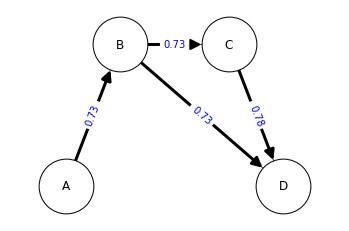

In [92]:
# Many environments only 2 samples in each environment
start_time = time.time()
num_experiments = 100
right_sink = {0: [], 1: ['D'], 2: ['C'], 3: ['B'], 4: ['A']}
right_edge = {'A': ['B'], 'B': ['C', 'D'], 'C': ['D'], 'D': []}
right_edge_list = build_edge_tuple(right_edge)
edge_sig = {}
for pair in right_edge_list:
    edge_sig[pair] = 0 
res = {}
correct_rate = 0 
for i in range(num_experiments):
    np.random.seed(i)
    num_env = 100000
    num_sample = 2
    alpha = 1
    beta = 3
    # Generate Data
    theta_a = np.random.beta(alpha, beta, num_env)
    theta_b = np.random.beta(alpha, beta, num_env)
    theta_c = np.random.beta(alpha, beta, num_env)
    theta_d = np.random.beta(alpha, beta, num_env)
    A = np.random.binomial(1, p = theta_a, size = (num_sample, num_env))
    B_factor = np.random.binomial(1, p = theta_b, size = (num_sample, num_env))
    C_factor = np.random.binomial(1, p = theta_c, size = (num_sample, num_env))
    D_factor = np.random.binomial(1, p = theta_d, size = (num_sample, num_env))
    B = (B_factor != A).astype(int)
    C = (C_factor != B).astype(int)
    D = (D_factor != (C*B)).astype(int)
    var_dict = {'A': A, 'B': B, 'C': C, 'D': D}

    sink_dict = test_topological_order(var_dict)
    # print(sink_dict)
    edge_dict = test_edge(sink_dict, var_dict)
    res[i] = (sink_dict, edge_dict)
    if sink_dict == right_sink and edge_dict == right_edge:
        correct_rate += 1 
    cur_edge_list = build_edge_tuple(edge_dict)
    for pair in right_edge_list:
        if pair in cur_edge_list:
            edge_sig[pair] += 1/num_experiments
    """
    else:
        print(i)
        print(sink_dict)
        print(edge_dict)
    """
    if i%10 ==0:
        print("Experiment %d finished." %(i)) 
        print("Progress: %.2f" %(correct_rate/num_experiments))
print("Final: %.2f" %(correct_rate/num_experiments))
print("Time Taken: %.6f" %(time.time() - start_time))
for k, v in edge_sig.items():
    v = round(v, 2)
    edge_sig[k] = v
print(edge_sig)
show_graph(right_edge, edge_sig)

# Experiment 8
$$A \rightarrow B \quad \text{and} \quad B \rightarrow C \quad \text{and} \quad C \rightarrow D \quad \text{and} \quad A\rightarrow C $$
$$
\theta_A \sim \text{Beta}(\alpha, \beta) \\
\theta_B \sim \text{Beta}(\alpha, \beta) \\
\theta_C \sim \text{Beta}(\alpha, \beta) \\
\theta_D \sim \text{Beta}(\alpha, \beta) \\
A \sim \text{Ber}(\theta_A) \\
B \sim \text{Ber}(\theta_B) \quad \text{xor} \quad A \\
C \sim \text{Ber}(\theta_C) \quad \text{xor} \quad B \times A \\
D \sim \text{Ber}(\theta_D) \quad \text{xor} \quad C \\
$$

Experiment 0 finished.
Progress: 0.00
Experiment 10 finished.
Progress: 0.08
Experiment 20 finished.
Progress: 0.15
Experiment 30 finished.
Progress: 0.21
Experiment 40 finished.
Progress: 0.27
Experiment 50 finished.
Progress: 0.31
Experiment 60 finished.
Progress: 0.38
Experiment 70 finished.
Progress: 0.46
Experiment 80 finished.
Progress: 0.53
Experiment 90 finished.
Progress: 0.59
Final: 0.62
Time Taken: 1402.971075
{('A', 'B'): 0.71, ('A', 'C'): 0.71, ('B', 'C'): 0.71, ('C', 'D'): 0.75}


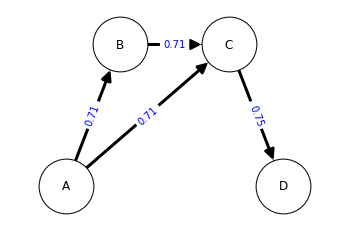

In [93]:
# Many environments only 2 samples in each environment
start_time = time.time()
num_experiments = 100
right_sink = {0: [], 1: ['D'], 2: ['C'], 3: ['B'], 4: ['A']}
right_edge = {'A': ['B', 'C'], 'B': ['C'], 'C': ['D'], 'D': []}
right_edge_list = build_edge_tuple(right_edge)
edge_sig = {}
for pair in right_edge_list:
    edge_sig[pair] = 0 
res = {}
correct_rate = 0 
for i in range(num_experiments):
    np.random.seed(i)
    num_env = 100000
    num_sample = 2
    alpha = 1
    beta = 3
    # Generate Data
    theta_a = np.random.beta(alpha, beta, num_env)
    theta_b = np.random.beta(alpha, beta, num_env)
    theta_c = np.random.beta(alpha, beta, num_env)
    theta_d = np.random.beta(alpha, beta, num_env)
    A = np.random.binomial(1, p = theta_a, size = (num_sample, num_env))
    B_factor = np.random.binomial(1, p = theta_b, size = (num_sample, num_env))
    C_factor = np.random.binomial(1, p = theta_c, size = (num_sample, num_env))
    D_factor = np.random.binomial(1, p = theta_d, size = (num_sample, num_env))
    B = (B_factor != A).astype(int)
    C = (C_factor != (B*A)).astype(int)
    D = (D_factor != C).astype(int)
    var_dict = {'A': A, 'B': B, 'C': C, 'D': D}

    sink_dict = test_topological_order(var_dict)
    # print(sink_dict)
    edge_dict = test_edge(sink_dict, var_dict)
    res[i] = (sink_dict, edge_dict)
    if sink_dict == right_sink and edge_dict == right_edge:
        correct_rate += 1 
    cur_edge_list = build_edge_tuple(edge_dict)
    for pair in right_edge_list:
        if pair in cur_edge_list:
            edge_sig[pair] += 1/num_experiments
    """
    else:
        print(i)
        print(sink_dict)
        print(edge_dict)
    """
    if i%10 ==0:
        print("Experiment %d finished." %(i)) 
        print("Progress: %.2f" %(correct_rate/num_experiments))
print("Final: %.2f" %(correct_rate/num_experiments))
print("Time Taken: %.6f" %(time.time() - start_time))
for k, v in edge_sig.items():
    v = round(v, 2)
    edge_sig[k] = v
print(edge_sig)
show_graph(right_edge, edge_sig)

# Experiment 9
$$A \rightarrow B \quad \text{and} \quad B \rightarrow C \quad \text{and} \quad C \rightarrow D \quad \text{and} \quad A\rightarrow D $$
$$
\theta_A \sim \text{Beta}(\alpha, \beta) \\
\theta_B \sim \text{Beta}(\alpha, \beta) \\
\theta_C \sim \text{Beta}(\alpha, \beta) \\
\theta_D \sim \text{Beta}(\alpha, \beta) \\
A \sim \text{Ber}(\theta_A) \\
B \sim \text{Ber}(\theta_B) \quad \text{xor} \quad A \\
C \sim \text{Ber}(\theta_C) \quad \text{xor} \quad B  \\
D \sim \text{Ber}(\theta_D) \quad \text{xor} \quad C \times A \\
$$

Experiment 0 finished.
Progress: 0.00
Experiment 10 finished.
Progress: 0.09
Experiment 20 finished.
Progress: 0.15
Experiment 30 finished.
Progress: 0.21
Experiment 40 finished.
Progress: 0.26
Experiment 50 finished.
Progress: 0.31
Experiment 60 finished.
Progress: 0.38
Experiment 70 finished.
Progress: 0.46
Experiment 80 finished.
Progress: 0.54
Experiment 90 finished.
Progress: 0.58
Final: 0.62
Time Taken: 1469.266802
{('A', 'B'): 0.73, ('A', 'D'): 0.73, ('B', 'C'): 0.73, ('C', 'D'): 0.78}


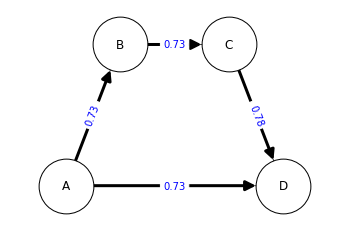

In [94]:
# Many environments only 2 samples in each environment
start_time = time.time()
num_experiments = 100
right_sink = {0: [], 1: ['D'], 2: ['C'], 3: ['B'], 4: ['A']}
right_edge = {'A': ['B', 'D'], 'B': ['C'], 'C': ['D'], 'D': []}
right_edge_list = build_edge_tuple(right_edge)
edge_sig = {}
for pair in right_edge_list:
    edge_sig[pair] = 0 
res = {}
correct_rate = 0 
for i in range(num_experiments):
    np.random.seed(i)
    num_env = 100000
    num_sample = 2
    alpha = 1
    beta = 3
    # Generate Data
    theta_a = np.random.beta(alpha, beta, num_env)
    theta_b = np.random.beta(alpha, beta, num_env)
    theta_c = np.random.beta(alpha, beta, num_env)
    theta_d = np.random.beta(alpha, beta, num_env)
    A = np.random.binomial(1, p = theta_a, size = (num_sample, num_env))
    B_factor = np.random.binomial(1, p = theta_b, size = (num_sample, num_env))
    C_factor = np.random.binomial(1, p = theta_c, size = (num_sample, num_env))
    D_factor = np.random.binomial(1, p = theta_d, size = (num_sample, num_env))
    B = (B_factor != A).astype(int)
    C = (C_factor != B).astype(int)
    D = (D_factor != (C*A)).astype(int)
    var_dict = {'A': A, 'B': B, 'C': C, 'D': D}

    sink_dict = test_topological_order(var_dict)
    # print(sink_dict)
    edge_dict = test_edge(sink_dict, var_dict)
    res[i] = (sink_dict, edge_dict)
    if sink_dict == right_sink and edge_dict == right_edge:
        correct_rate += 1 
    cur_edge_list = build_edge_tuple(edge_dict)
    for pair in right_edge_list:
        if pair in cur_edge_list:
            edge_sig[pair] += 1/num_experiments
    """
    else:
        print(i)
        print(sink_dict)
        print(edge_dict)
    """
    if i%10 ==0:
        print("Experiment %d finished." %(i)) 
        print("Progress: %.2f" %(correct_rate/num_experiments))
print("Final: %.2f" %(correct_rate/num_experiments))
print("Time Taken: %.6f" %(time.time() - start_time))
for k, v in edge_sig.items():
    v = round(v, 2)
    edge_sig[k] = v
print(edge_sig)
show_graph(right_edge, edge_sig)